## Set up simple flow

Move current directory to project root

In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path

if 'project_root' not in dir():
    project_root = Path.cwd().parent
    
os.chdir(project_root)

Toy dataset: Createa a `D` dimensional dataset by sampling from a `D` dimensional Gaussian and then projecting it back onto a `D-1` dimensional sphere.

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from model_zoo.datasets.generated import Sphere
from model_zoo.datasets.utils import OmitLabels
D = 2

dataset = Sphere('', 'test', manifold_dim=D-1, ambient_dim=D, mu=-3 * np.ones(D) )
device = 'cpu' if not torch.cuda.is_available() else 'cuda:4'
dataset = dataset.to(device)
dataloader = DataLoader(OmitLabels(dataset), batch_size=50)

Implement a visualization function for data that uses PCA if it is more than 2-dimensional.

In [3]:
def plot_with_pca(datas, labels, alphas=None, title=None):
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 8))
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    datas = [data.cpu() for data in datas]
    all_data = torch.cat(datas, dim=0).cpu().numpy()
    if all_data.shape[1] > 2:
        pca = PCA(n_components=2)
        pca.fit(all_data)
    if alphas is None:
        alphas = [1. for _ in datas]
    for data, label, alpha in zip(datas, labels, alphas):
        if data.shape[1] > 2:
            data = pca.transform(data.cpu().numpy())
        plt.scatter(data[:, 0], data[:, 1], label=label, alpha=alpha)
    plt.title(title)
    plt.legend()
    plt.show()

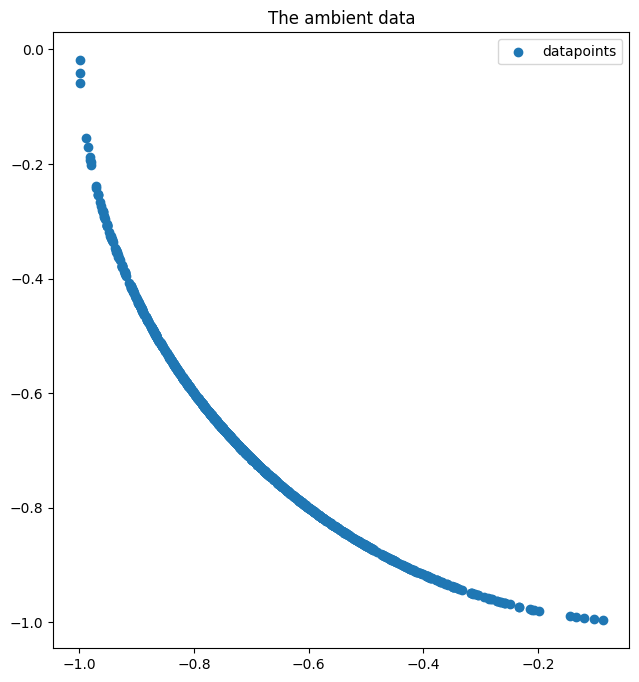

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plot_with_pca([dataset.x], ["datapoints"], title="The ambient data")
# plt.scatter(dataset.x.cpu()[:, 0], dataset.x.cpu()[:, 1])
# plt.title("The ambient data")
# plt.show()

Construct a flow consisting of one simple linear transformation

In [5]:
from torch import optim
from model_zoo.density_estimator.flow import NormalizingFlow

flow = NormalizingFlow(
    dim=D,
    transform=[{
        'class_path': 'nflows.transforms.lu.LULinear',
        'init_args': {
            'features': D
        },
    }],
    scale_data=False,
).to(device)

optimizer = optim.Adam(flow.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda step: 1
)

flow.optimizer = optimizer
flow.lr_scheduler = scheduler
flow.data_min = torch.ones_like(flow.data_min) * dataset.get_data_min()
flow.data_max = torch.ones_like(flow.data_max) * dataset.get_data_max()



In [6]:
from tqdm import tqdm
for epoch in tqdm(range(1000), desc="Training the flow model"):
    for batch in dataloader:
        flow.train_batch(batch)
    

Training the flow model:   0%|          | 0/1000 [00:00<?, ?it/s]

Training the flow model: 100%|██████████| 1000/1000 [01:26<00:00, 11.63it/s]


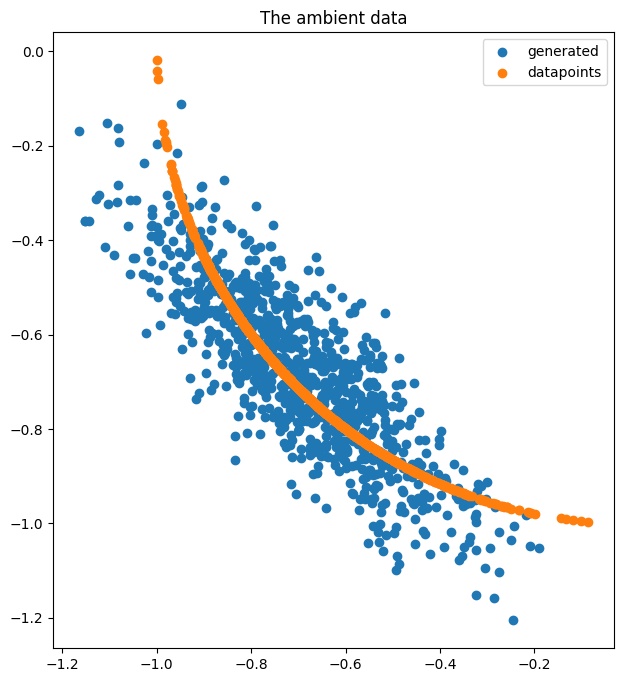

In [7]:

gen_sample = flow.sample(1000).cpu().detach()
plot_with_pca([gen_sample, dataset.x], ["generated", "datapoints"], alphas=[1.0, 1.0], title="The ambient data")
# plt.scatter(gen_sample[:, 0], gen_sample[:, 1])
# plt.show()

## Evaluate 

In [8]:
from ood.methods.linear_approximations.latent_statistics import EllipsoidCDFStatsCalculator
from ood.methods.linear_approximations.encoding_model import EncodingFlow


ellipsoid_calc = EllipsoidCDFStatsCalculator(
    flow, 
    atol=0.001,
    lim=10000,
    encoding_model_class = EncodingFlow, 
    encoding_model_args = {
        'use_functorch': True, 
        'use_forward_mode': True, 
        'use_vmap': False,
        'chunk_size': 1,
        'diff_transform': False,
    }, 
    verbose=1,
)
# create a dataloader out of the first 3 batches of dataloader

data_vec = dataloader.dataset[np.random.randint(0, len(dataloader.dataset), size=10)]

sampling_loader = torch.utils.data.DataLoader(
    data_vec,
    batch_size=2,
    shuffle=False,
)
jax, z_values = ellipsoid_calc.encoding_model.calculate_jacobian(
    loader=sampling_loader,
)

Sanity check on the Jacobian calculator itself

In [9]:
for x_, z_, jac_ in zip(sampling_loader, z_values, jax):
    for x, z, jac in zip(x_, z_, jac_):
        x = x.to(device)
        z__ = ellipsoid_calc.encoding_model.encode(x, batchwise=False)
        z = z.to(device)
        jac = jac.to(device)
        
        u = torch.randn_like(x)
        x_perturbed = x + u
        z_perturbed = ellipsoid_calc.encoding_model.encode(x_perturbed, batchwise=False)
        
        approximated_x_perturbed = x + (jac @ (z_perturbed - z).reshape(-1, 1)).flatten()
        print("J = ", jac)
        print(
            "delta", 
            (approximated_x_perturbed - x_perturbed).tolist()
        )
        print("^x* = ", approximated_x_perturbed.tolist())
        print("x* =", x_perturbed.tolist())
        print("u =", u.tolist())
        print("x =", x.tolist())
        print("***")
        assert torch.allclose(approximated_x_perturbed, x_perturbed, atol=1e-4), "The approximation is not correct!"
        

J =  tensor([[ 0.1752, -0.0546],
        [-0.1149,  0.1369]], device='cuda:4')
delta [0.0, 1.1920928955078125e-07]
^x* =  [-0.43450409173965454, -0.3450165092945099]
x* = [-0.43450409173965454, -0.34501662850379944]
u = [0.21178054809570312, 0.41807982325553894]
x = [-0.6462846398353577, -0.7630964517593384]
***
J =  tensor([[ 0.1752, -0.0546],
        [-0.1149,  0.1369]], device='cuda:4')
delta [-1.7881393432617188e-07, 2.384185791015625e-07]
^x* =  [-0.5759714245796204, 0.37431395053863525]
x* = [-0.575971245765686, 0.37431371212005615]
u = [0.14803794026374817, 1.0641039609909058]
x = [-0.7240092158317566, -0.6897902488708496]
***
J =  tensor([[ 0.1752, -0.0546],
        [-0.1149,  0.1369]], device='cuda:4')
delta [-2.384185791015625e-07, 2.384185791015625e-07]
^x* =  [1.0654994249343872, 0.01495903730392456]
x* = [1.0654996633529663, 0.014958798885345459]
u = [1.734304428100586, 0.7583968639373779]
x = [-0.6688047647476196, -0.7434380650520325]
***
J =  tensor([[ 0.1752, -0.0546],


Sanity check on the sampling itself

sampling from ellipsoids: 100%|██████████| 5/5 [00:09<00:00,  1.98s/it]


all the maximum distances
[0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]


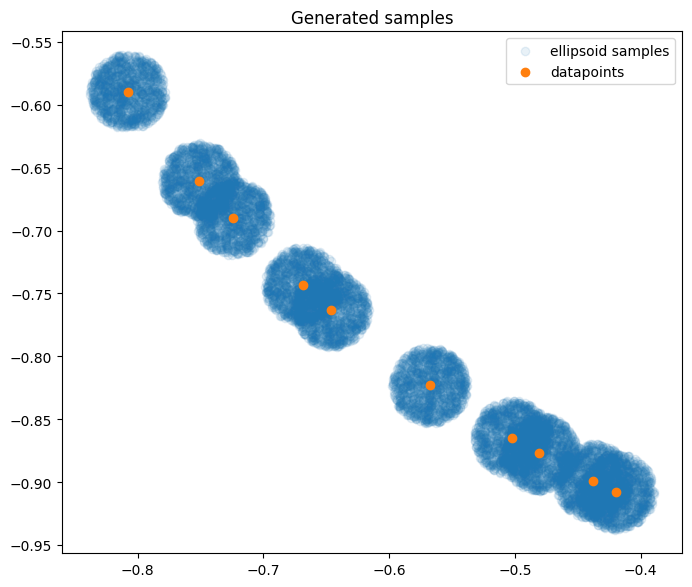

In [10]:
# sample from the ellipsoids and then visualize

ellipsoid_samples = ellipsoid_calc.sample(0.03, sampling_loader, 1000, disregard_radii=False)

all_samples_ = []
all_dvec_ = []
all_dist = []
for sample, dvec in zip(ellipsoid_samples, data_vec):
    all_samples_.append(sample.cpu())
    all_dvec_.append(dvec.cpu().unsqueeze(0)) 
    dist = torch.norm(sample.cpu() - dvec.cpu().repeat(sample.shape[0], 1), p = 2, dim=1)
    all_dist.append(round(dist.max().item(), 3))

print("all the maximum distances")
print(all_dist)

plot_with_pca(
    [torch.cat(all_samples_, dim=0), torch.cat(all_dvec_, dim=0)],
    ["ellipsoid samples", "datapoints"],
    alphas=[0.1, 1.0],
    title="Generated samples"
)
#     plt.scatter(sample[:, 0].cpu(), sample[:, 1].cpu(), alpha=0.1)
#     plt.scatter(dvec[:1].cpu(), dvec[1:].cpu())
# plt.show()

# TODO: add a numerically extreme example!

## Checking the cdf calculator

In [11]:
r = 0.3

statistics = ellipsoid_calc.calculate_statistics(r, sampling_loader)
idx = 0
gen_samples = flow.sample(100000).cpu().detach().numpy()
for i, x_ in enumerate(sampling_loader):
    for x in x_:
        succ = 0
        for y in tqdm(gen_samples, desc=f"Calculating empirical cdf for sample {i + 1}"):
            if np.linalg.norm(x.cpu().numpy() - y, ord=2) <= r:
                succ += 1

        print(succ / len(gen_samples))
        print(statistics[idx])
        idx += 1
        print("***")
    


Calculating empirical cdf for sample 1:   0%|          | 0/100000 [00:00<?, ?it/s]

Calculating empirical cdf for sample 1: 100%|██████████| 100000/100000 [00:02<00:00, 37610.35it/s]


0.72609
0.7258932093345036
***


Calculating empirical cdf for sample 1: 100%|██████████| 100000/100000 [00:02<00:00, 37752.62it/s]


0.7573
0.7579358984053723
***


Calculating empirical cdf for sample 2: 100%|██████████| 100000/100000 [00:02<00:00, 37609.86it/s]


0.74318
0.7431635336950984
***


Calculating empirical cdf for sample 2: 100%|██████████| 100000/100000 [00:02<00:00, 37667.43it/s]


0.68252
0.6850374034722815
***


Calculating empirical cdf for sample 3: 100%|██████████| 100000/100000 [00:02<00:00, 37728.95it/s]


0.52635
0.526207380071272
***


Calculating empirical cdf for sample 3: 100%|██████████| 100000/100000 [00:02<00:00, 37724.36it/s]


0.49018
0.4899601706922436
***


Calculating empirical cdf for sample 4: 100%|██████████| 100000/100000 [00:02<00:00, 36746.58it/s]


0.63025
0.6302498905100913
***


Calculating empirical cdf for sample 4: 100%|██████████| 100000/100000 [00:02<00:00, 35626.64it/s]


0.74661
0.7482542100172465
***


Calculating empirical cdf for sample 5: 100%|██████████| 100000/100000 [00:02<00:00, 36401.53it/s]


0.42067
0.418994812731208
***


Calculating empirical cdf for sample 5: 100%|██████████| 100000/100000 [00:02<00:00, 36501.22it/s]


0.38962
0.38877220915435234
***


## Checking the Gaussian Convolutions

Here we do sanity checks on the linear approximation ideas for Gaussian convolutions.

In [27]:
from ood.methods.linear_approximations.latent_statistics import GaussianConvolutionStatsCalculator
from ood.methods.linear_approximations.encoding_model import EncodingFlow


gaussian_calc = GaussianConvolutionStatsCalculator(
    flow, 
    encoding_model_class = EncodingFlow, 
    encoding_model_args = {
        'use_functorch': True, 
        'use_forward_mode': True, 
        'use_vmap': False,
        'chunk_size': 1,
        'diff_transform': False,
    }, 
    verbose=1,
)
# create a dataloader out of the first 3 batches of dataloader

data_vec = dataloader.dataset[np.random.randint(0, len(dataloader.dataset), size=10)]

sampling_loader = torch.utils.data.DataLoader(
    data_vec,
    batch_size=2,
    shuffle=False,
)
jax, z_values = gaussian_calc.encoding_model.calculate_jacobian(
    loader=sampling_loader,
)
for x_, z_, jac_ in zip(sampling_loader, z_values, jax):
    for x, z, jac in zip(x_, z_, jac_):
        x = x.to(device)
        z__ = gaussian_calc.encoding_model.encode(x, batchwise=False)
        z = z.to(device)
        jac = jac.to(device)
        
        u = torch.randn_like(x)
        x_perturbed = x + u
        z_perturbed = gaussian_calc.encoding_model.encode(x_perturbed, batchwise=False)
        
        approximated_x_perturbed = x + (jac @ (z_perturbed - z).reshape(-1, 1)).flatten()
        assert torch.allclose(approximated_x_perturbed, x_perturbed, atol=1e-4), "The approximation is not correct!"
        

sampling from latent gaussians - fail [0/2]: 100%|██████████| 5/5 [00:00<00:00, 78.90it/s]


all the avg. distances
[0.022, 0.022, 0.021, 0.021, 0.021, 0.02, 0.022, 0.022, 0.021, 0.022]


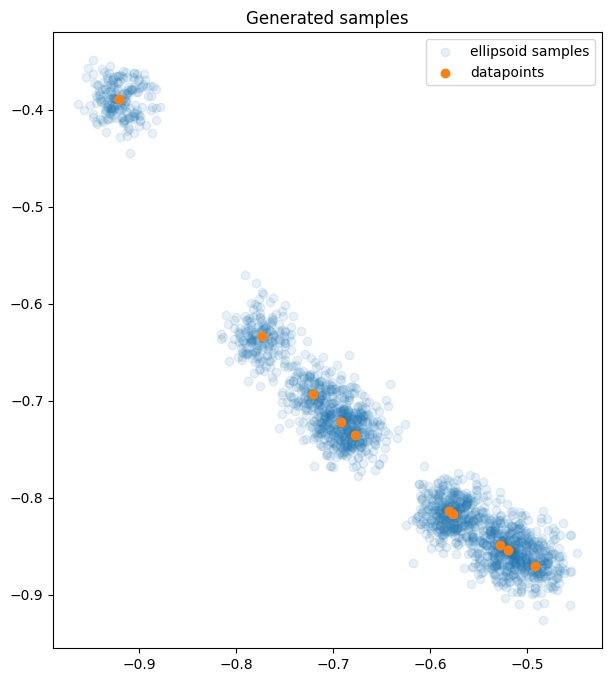

In [28]:
# sample from the ellipsoids and then visualize

ellipsoid_samples = gaussian_calc.sample(0.0003, sampling_loader, 200)

all_samples_ = []
all_dvec_ = []
all_dist = []
for sample, dvec in zip(ellipsoid_samples, data_vec):
    all_samples_.append(sample.cpu())
    all_dvec_.append(dvec.cpu().unsqueeze(0)) 
    dist = torch.norm(sample.cpu() - dvec.cpu().repeat(sample.shape[0], 1), p = 2, dim=1)
    all_dist.append(round(dist.mean().item(), 3))

print("all the avg. distances")
print(all_dist)

plot_with_pca(
    [torch.cat(all_samples_, dim=0), torch.cat(all_dvec_, dim=0)],
    ["ellipsoid samples", "datapoints"],
    alphas=[0.1, 1.0],
    title="Generated samples"
)
#     plt.scatter(sample[:, 0].cpu(), sample[:, 1].cpu(), alpha=0.1)
#     plt.scatter(dvec[:1].cpu(), dvec[1:].cpu())
# plt.show()

## checking the evaluated Gaussians

In [29]:
from math import pow, pi, exp, log

r = 0.001

statistics = gaussian_calc.calculate_statistics(r, sampling_loader)
idx = 0
gen_samples = flow.sample(100000).cpu().detach().numpy()
for i, x_ in enumerate(sampling_loader):
    for x in x_:
        all_pdfs = []
        for y in tqdm(gen_samples, desc=f"Calculating empirical cdf for sample {i + 1}"):
            # calculate the pdf of an isotropic Gaussian centered at x with covariance matrix r*I at y
            pdf = exp(-np.linalg.norm(y - x.cpu().numpy(), ord=2) ** 2 / (2 * r)) / pow(r * pi * 2, gen_samples.shape[1]/2)
            all_pdfs.append(pdf)
        print("calculated for point", x)
        print("Empirical log convolution:", log(sum(all_pdfs)) - log(len(all_pdfs)))
        print("Exact log convolution with linear approximation:", statistics[idx])
        idx += 1
        print("***")
    


Calculating empirical cdf for sample 1: 100%|██████████| 100000/100000 [00:03<00:00, 29692.36it/s]


calculated for point tensor([-0.5197, -0.8543], device='cuda:4')
Empirical log convolution: 1.6528265848095867
Exact log convolution with linear approximation: 1.7534409761428833
***


Calculating empirical cdf for sample 1: 100%|██████████| 100000/100000 [00:03<00:00, 29610.36it/s]


calculated for point tensor([-0.5766, -0.8170], device='cuda:4')
Empirical log convolution: 1.8651540522060515
Exact log convolution with linear approximation: 1.9804836511611938
***


Calculating empirical cdf for sample 2: 100%|██████████| 100000/100000 [00:03<00:00, 29596.92it/s]


calculated for point tensor([-0.7204, -0.6935], device='cuda:4')
Empirical log convolution: 2.08224152964166
Exact log convolution with linear approximation: 2.183502674102783
***


Calculating empirical cdf for sample 2: 100%|██████████| 100000/100000 [00:03<00:00, 29596.29it/s]


calculated for point tensor([-0.6773, -0.7357], device='cuda:4')
Empirical log convolution: 2.072243980314264
Exact log convolution with linear approximation: 2.1716301441192627
***


Calculating empirical cdf for sample 3:  96%|█████████▌| 95514/100000 [00:03<00:00, 29634.15it/s]


KeyboardInterrupt: 

: 